File exists: True
(250, 337) (250, 337)


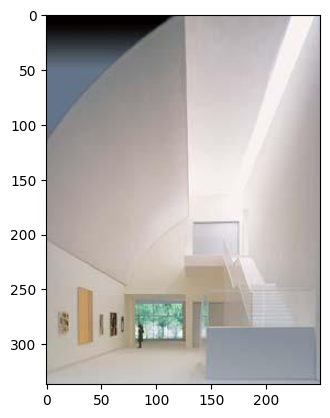

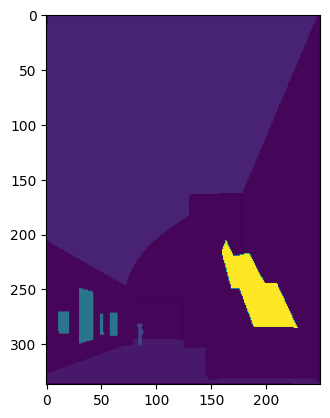

In [18]:
import torch.utils.data as data
from torch.utils.data import DataLoader
import os
import glob
import torch
import pathlib
from torchvision import transforms
from matplotlib import pyplot as plt
from pathlib import Path

#from torchvision.transforms import v2
import PIL.Image

# the following class was taken as a template from https://discuss.pytorch.org/t/loading-ade20k-dataset/48684/2
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','training','*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
             # we use `pathlib.Path(img_path).stem` to extract only the file name
             self.mask_files.append(os.path.join(folder_path,'annotations','training',pathlib.Path(img_path).stem + ".png")) 

        # apparently this is necessary     
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size=(480, 480)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.to(torch.float32)),
            ]
        )

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = PIL.Image.open(img_path)
            label = PIL.Image.open(mask_path)
            print(data.size, label.size)  # Check image dimensions
            # Displaying images (optional for debugging)
            plt.imshow(data)
            plt.show()
            plt.imshow(label)
            plt.show()
            return self.transforms(data), self.transforms(label)

    def __len__(self):
        return len(self.img_files)



folder_path = Path('./data/mseg_dataset/ADEChallengeData2016')
print(f"File exists: {folder_path.exists()}")
loader = DataLoaderSegmentation(folder_path=folder_path)

data_loader = DataLoader(loader,num_workers=4, batch_size=2, shuffle=False, pin_memory=True)

foo = loader.__getitem__(10)
